In [1]:
import pertpy as pt
import scanpy as sc
import numpy as np

import random
import torch
import sklearn
import os
def set_seed(seed: int):
    # Set Python random seed
    random.seed(seed)

    # Set NumPy random seed
    np.random.seed(seed)

    # Set PyTorch random seed
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # If using multi-GPU.

        # Ensure deterministic behavior in PyTorch (can slow down computations)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # Set sklearn random seed
    sklearn.utils.check_random_state(seed)

    # Set environment variable for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(123)

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/anndata/utils.py:429: FutureWar

In [2]:
adata=sc.read_h5ad("./data/t1d.h5ad")
print(adata)
print(adata.X[:10,:10])

AnnData object with n_obs × n_vars = 69645 × 26099
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1.2', 'seurat_clusters', 'disease_state', 'cell_label', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'citation', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_pca', 'X_umap'
  (0, 1)	1.076574683189392
  (3, 1)	0.6022599935531616
  (4, 1)	0.32389

In [3]:
import pandas as pd
df = pd.DataFrame(adata.obs[['disease_state','donor_id']].copy())

# Remove duplicated rows
unique_df = df.drop_duplicates()

# Construct a dictionary mapping the first column to the second column
mapping_dict = dict(zip(unique_df['donor_id'], unique_df['disease_state']))

print("Unique DataFrame:")
print(unique_df)
print("\nMapping Dictionary:")
print(mapping_dict)
print(np.unique(unique_df['disease_state'].values,return_counts=True))

Unique DataFrame:
                    disease_state donor_id
AAACCTGAGGTGTGGT-1        Control  HPAP022
AAACCTGCACCTTGTC-2        Control  HPAP026
AAACGGGAGTAGCGGT-3        Control  HPAP034
AAACCTGCAGCTGTAT-4        Control  HPAP035
AAACCTGAGACGCAAC-5        Control  HPAP036
AAACCTGCACCAGATT-6        Control  HPAP037
AAACCCAAGGACATCG-7        Control  HPAP039
AAACCCAAGTAGTCAA-8        Control  HPAP040
AAACCCACAACCTAAC-9        Control  HPAP042
AAACGAACAAGCGCTC-10       Control  HPAP044
AAACCCAAGCCTCTGG-11       Control  HPAP047
AAACCTGAGACTGTAA-12           AAB  HPAP019
AAACCTGCAATGGATA-13           AAB  HPAP024
AAACCTGGTTCTGGTA-14           AAB  HPAP029
AAACCCACAGACTCTA-15           AAB  HPAP038
AAACGAAAGAATCGTA-16           AAB  HPAP043
AAACCCAAGACCATAA-17           AAB  HPAP045
AAACCCAAGCGCGTTC-18           AAB  HPAP049
AAACCCACAGTATTCG-19           AAB  HPAP050
AAACCTGAGGCACATG-20           T1D  HPAP020
AAACCTGAGCGTTGCC-21           T1D  HPAP021
AAACCTGCATCCTAGA-22           T1D  H

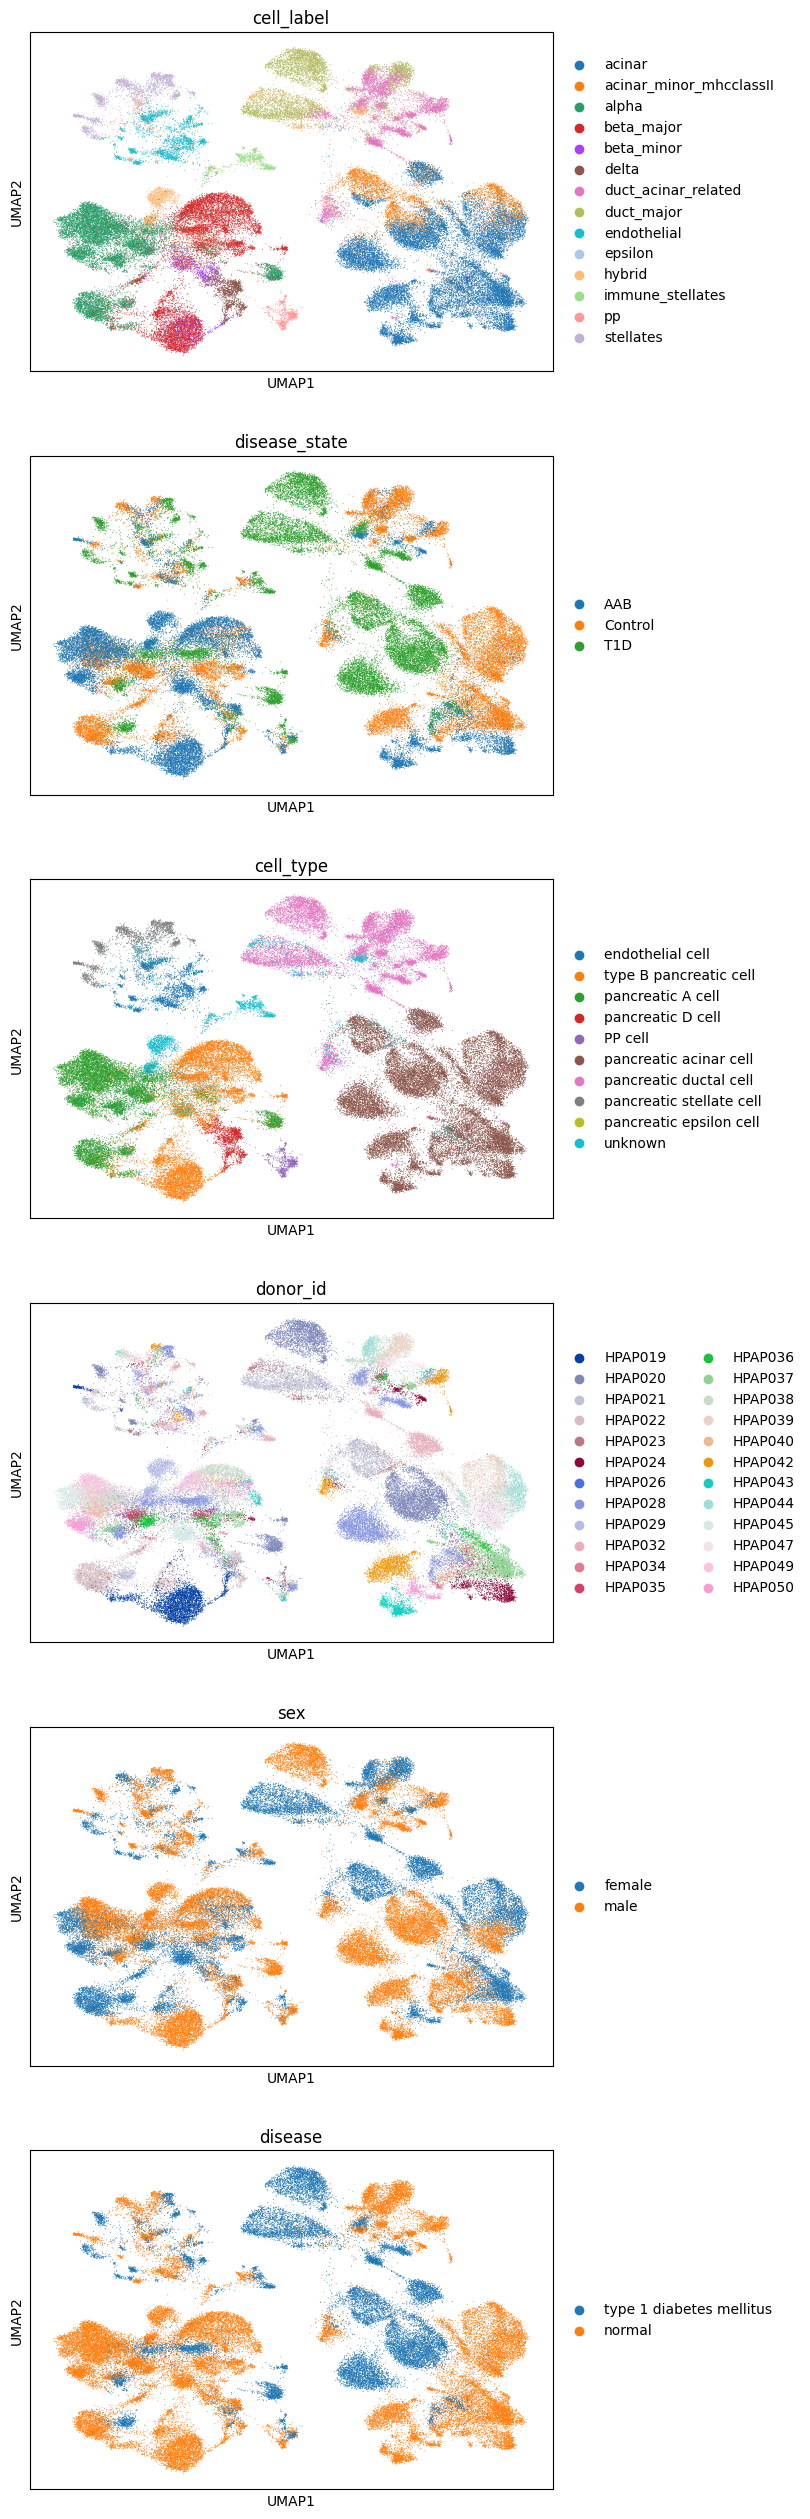

In [4]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var["highly_variable"]]
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color=["cell_label","disease_state","cell_type","donor_id","sex","disease"],ncols=1)

In [5]:
from ndreamer import NDreamer

model = NDreamer(adata, condition_key="disease_state", contorl_name='Control', num_hvg=2000, require_batch=True,
                            batch_key='donor_id',
                            resolution_low=0.5, resolution_high=7, cluster_method="Leiden", embedding_dim=512,
                            codebooks=[1024 for i in range(32)],
                            codebook_dim=8, encoder_hidden=[1024, 512], decoder_hidden=[512, 1024], z_dim=256,
                            cos_loss_scaler=20, random_seed=123, batch_size=1024, epoches=10, lr=1e-3,
                            triplet_margin=5,independent_loss_scaler=1000, save_pth="./t1d/",
                            developer_test_mode=False,
                            library_size_normalize_adata=False,
                            save_preprocessed_adata_path="./t1d/preprocessed.h5ad",
                            KL_scaler=5e-3, reconstruct_scaler=1, triplet_scaler=5, num_triplets_per_label=15,
                            tau=0.01, commitment_loss_scaler=1, cluster_correlation_scaler=50,reset_threshold=1/1024,
                            reset_interval=30,try_identify_cb_specific_subtypes=False,
                            local_neighborhood_loss_scaler=1,local_neighbor_sigma=1,
                            try_identify_perturb_escaped_cell=False,n_neighbors=20,
                            local_neighbor_across_cluster_scaler=20)

model.train_model()
model.get_modifier_space()

model.decompose_true_expression_batch_effect_all(nearest_neighbor=1,bandwidth=1)
model.Estmiate_ITE_all(nearest_neighbor=1,bandwidth=1)

Start data preprocessing
Original adata.obs[donor_id] back up to adata.obs['batch_backup']
Original adata.obs[condition_key] back up to adata.obs['condition_backup']
Condition mapping to adata.obs['condition']: {'Control': 0, 'AAB': 1, 'T1D': 2}
Condition mapping to adata.obs['batch']: {'HPAP022': 0, 'HPAP026': 1, 'HPAP034': 2, 'HPAP035': 3, 'HPAP036': 4, 'HPAP037': 5, 'HPAP039': 6, 'HPAP040': 7, 'HPAP042': 8, 'HPAP044': 9, 'HPAP047': 10, 'HPAP019': 11, 'HPAP024': 12, 'HPAP029': 13, 'HPAP038': 14, 'HPAP043': 15, 'HPAP045': 16, 'HPAP049': 17, 'HPAP050': 18, 'HPAP020': 19, 'HPAP021': 20, 'HPAP023': 21, 'HPAP028': 22, 'HPAP032': 23}
Calculating the clusters
Unique groups: ['0_Control' '10_Control' '11_AAB' '12_AAB' '13_AAB' '14_AAB' '15_AAB'
 '16_AAB' '17_AAB' '18_AAB' '19_T1D' '1_Control' '20_T1D' '21_T1D'
 '22_T1D' '23_T1D' '2_Control' '3_Control' '4_Control' '5_Control'
 '6_Control' '7_Control' '8_Control' '9_Control']
Finished clustering
Data preprocessing done
Remaining number of cel

Overall Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1/100 | All Loss: 185.3726 | Neighborhood Loss: 46.8257 | Triplet Loss: 11.6558 | Reconstruction Loss: 8.4770 | Independent Loss: 125.6133 | KL Loss: 0.3253 | Commitment Loss: 0.5605 | Dependent Loss: -8.0850
Resetting 795 unused embeddings.
Resetting 773 unused embeddings.
Resetting 772 unused embeddings.
Resetting 775 unused embeddings.
Resetting 780 unused embeddings.
Resetting 765 unused embeddings.
Resetting 777 unused embeddings.
Resetting 778 unused embeddings.
Resetting 770 unused embeddings.
Resetting 767 unused embeddings.
Resetting 793 unused embeddings.
Resetting 766 unused embeddings.
Resetting 765 unused embeddings.
Resetting 766 unused embeddings.
Resetting 772 unused embeddings.
Resetting 778 unused embeddings.
Resetting 798 unused embeddings.
Resetting 768 unused embeddings.
Resetting 770 unused embeddings.
Resetting 773 unused embeddings.
Resetting 766 unused embeddings.
Resetting 785 unused embeddings.
Resetting 755 unused embeddings.
Resetting 793 unused embe

KeyboardInterrupt: 